# Parametric pumping below the qubit frequency

We can also apply the Floquet analysis to examine parametric driving of the transmon below its resonance frequency, which is not a typical situation for transmon readout.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = cycler(plt.rcParams["axes.prop_cycle"])
ls_cycler = cycler(ls=["-", "--", "-.", ":"])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

In [2]:
filepath = ft.generate_file_path("h5py", "transmon_parametric_floquet", "out")

num_states = 20
qubit_params = {"EJ": 20.0, "EC": 0.2, "ng": 0.25, "ncut": 41}
tmon = scq.Transmon(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]


# Express operators in eigenbasis of transmon
def get_H0_H1(qubit_instance: scq.GenericQubit) -> tuple[qt.Qobj, qt.Qobj]:
    hilbert_space = scq.HilbertSpace([qubit_instance])
    hilbert_space.generate_lookup()
    evals = hilbert_space["evals"][0][0:num_states]
    H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
    H1 = hilbert_space.op_in_dressed_eigenbasis(qubit_instance.n_operator)
    return H0, H1


H0, H1 = get_H0_H1(tmon)

omega_d_values = 2.0 * np.pi * np.linspace(1.5, 2.0, 60)
chi_ac_values = 2.0 * np.pi * np.linspace(0.0, 0.8, 59)
chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_values)
drive_amplitudes = chi_to_amp.amplitudes_for_omega_d(chi_ac_values)

model = ft.Model(
    H0, H1, omega_d_values=omega_d_values, drive_amplitudes=drive_amplitudes
)

In [ ]:
filepath = ft.generate_file_path("h5py", "transmon_floquet_parametric", "out")
floquet_analysis = ft.FloquetAnalysis(
    model, state_indices=state_indices, options=ft.Options(num_cpus=6)
)
data_vals = floquet_analysis.run(filepath=filepath)

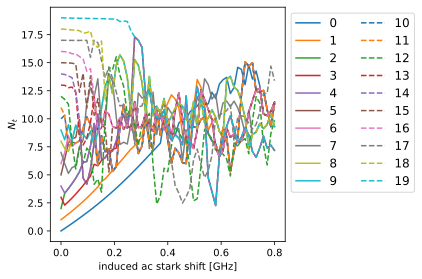

In [8]:
omega_d_idx = 59
fig, ax = plt.subplots(figsize=(6, 4))
for curve_idx, sty in zip(range(num_states), color_ls_alpha_cycler, strict=False):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        np.array(data_vals["avg_excitation"])[omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel(r"$N_{t}$")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

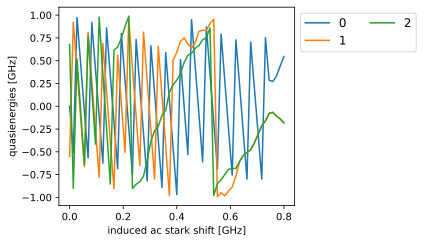

In [9]:
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(range(3), color_ls_alpha_cycler, strict=False):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        data_vals["quasienergies"][omega_d_idx, :, curve_idx] / 2 / np.pi,
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel("quasienergies [GHz]")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()